In [1]:
import sys
sys.path.append("../src")
from time_series import Collection, find_ders, find_files
import matplotlib.pyplot as plt
import numpy as np

import time_series
import brownian
from importlib import reload
reload(time_series)
reload(brownian)

from time_series import Collection, CollectionWeighing, TimeSeries, find_ders, find_files, parse_fname
from brownian import (abc_guess, get_krhoA, get_jac_krhoA, get_m123, get_jac_m123,
     kB, gaussian_func, psd_func, psd_abc_func, msd_func, pac_func, vac_func, logbin_func, bin_func)
import matplotlib.pyplot as plt
import numpy as np
from os import path
from scipy.special import gamma
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
from scipy.linalg import block_diag


from matplotlib import rc
fontsize = 10
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.latex.preamble":
        r'\usepackage{upgreek}',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}

plt.rcParams.update(fontstyle)
letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"] 
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()] 
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):     
    letters = letters_map[mode]     
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,             
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)


def make_objective(model, freq, psd, n):
    """ Construct negative log-likelihood objective function"""
    c = np.sum(np.log(gamma(n)) - n*np.log(n)-(n-1)*np.log(psd))
    def objective(popts):
        model_psd = model(freq, *popts)
        obj = n*np.sum(np.log(model_psd) + psd/model_psd)
        #obj+=c
        return obj
    return objective


def make_objective_jac(model, freq, psd, n):
    """ Construct derivative of negative log-likelihood objective function"""
    def fun_and_jac(popts):
        model_psd = model(freq, *popts)
        obj = n*np.sum(np.log(model_psd) + psd/model_psd)
        #obj+=c
        ffs = [1, freq**2, freq**4]
        jac = np.array([n * np.sum((model_psd + psd)*ff) for ff in ffs])
        return obj/len(psd), jac/len(psd)
    return fun_and_jac

#https://github.com/matplotlib/matplotlib/issues/21688
##from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)
    
# https://github.com/matplotlib/matplotlib/issues/5830 
def get_camera_position(ax):     
    "returns the camera position for 3D axes in cartesian coordinates"     
    r = np.sqrt(np.square(ax.xy_viewLim.max).sum())     
    theta, phi = np.radians((90 - ax.elev, ax.azim))    
    return np.array(sph2cart(r, theta, phi), ndmin=2).T   

def sph2cart(r, theta, phi):     
    "spherical to cartesian transformation."     
    x = r * np.sin(theta) * np.cos(phi)     
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)     
    return x, y, z   

def gauss_func3d(x, C, mu1, mu2, mu3, v11, v12, v13, v22, v23, v33):    
    "3d Gaussian with scale 3, mean mu, and covariance V"     
    mu = np.array([mu1, mu2, mu3])    
    V = np.array([[v11, v12, v13], [v12, v22, v23], [v13, v23, v33]])    
    Vinv = np.linalg.inv(V)     
    x = np.array(x)     
    xbar = x - mu[:, np.newaxis]     
    g = np.einsum("ik, ij, jk -> k", xbar, Vinv, xbar)     
    return C * np.exp(-g / 2)  

def cov_to_cor(cov):
    u = np.sqrt(np.diag(cov))
    return cov / np.outer(u, u)

def gauss_func3d(x, C, mu1, mu2, mu3, v11, v12, v13, v22, v23, v33):     
    "3d Gaussian with scale 3, mean mu, and covariance V"     
    mu = np.array([mu1, mu2, mu3])     
    V = np.array([[v11, v12, v13], [v12, v22, v23], [v13, v23, v33]])     
    Vinv = np.linalg.inv(V)     
    x = np.array(x)     
    xbar = x - mu[:, np.newaxis]     
    g = np.einsum("ik, ij, jk -> k", xbar, Vinv, xbar)
    return C * np.exp(-g / 2)

def accumulate_vars(C, Nbins=30, taumax=None, show=False, dhist_min=0, plot=False):
    lb = np.min([np.min(D.x) for D in C.collection])
    ub = np.max([np.max(D.x) for D in C.collection])
    C.average("HIST", taumax=taumax, lb=lb, ub=ub, Nbins=Nbins, remove_mean=True)
    vars_list = []
    dvars_list = []
    hist_list = []
    for D in C.collection:
        hist, bins = D.hist, D.bins
        var, var_cov = curve_fit(gaussian_func, bins, hist, p0=[np.var(D.x)], bounds=(0, np.inf))
        var = var[0]
        dvar = np.sqrt(var_cov[0,0] + (dhist_min)**2)
        vars_list.append(var)
        dvars_list.append(dvar)
        hist_list.append(hist)
        if plot:
            plt.plot(bins, hist, alpha=0.4)
            plt.plot(bins, gaussian_func(bins, var))
        plt.show()
    var = np.mean(vars_list)
    dvar = np.sqrt(dvar**2 + np.var(vars_list))
    hist = np.mean(hist_list, axis=0)
    dhist = np.std(hist_list, axis=0)
    C.Vvar = var
    C.dVvar = dvar
    C.Vhist = hist
    C.dVhist = dhist
    C.Vbins = bins
    return var, dvar 

def var_func(x, Nbins=20, show=False):
    hist, edges = np.histogram(x, bins="auto", density=True)
    bins = edges[:-1] + np.diff(edges) / 2
    var_opt, std_cov = curve_fit(gaussian_func, bins, hist, p0=[np.var(x)], bounds=(1e-16, np.inf), maxfev=2000)
    if show:
        plt.step(bins, hist, where="mid")
        plt.plot(bins, gaussian_func(bins, *var_opt, mean=np.mean(x)))
        plt.show()
    return var_opt[0] 
    
    


In [2]:
R = 1.51e-6
dR = 0.044e-6

dT = 0.8
deta = 1.8e-7

Npts_time = 256
taumax = 83.886e-3
window = "hamming"

In [3]:
base_der = "../weighing/data"

In [4]:
date_ders = find_ders(base_der) # Experimental data is organized by date-collected
date_ders

['../weighing/data/20190920',
 '../weighing/data/20191111',
 '../weighing/data/20220330',
 '../weighing/data/20191210',
 '../weighing/data/20191115']

In [5]:
date_der =  date_ders[3]
run_ders = find_ders(date_der)
print(f"Available runs: {run_ders}")

Available runs: ['../weighing/data/20191210/power_scan', '../weighing/data/20191210/noise', '../weighing/data/20191210/cal', '../weighing/data/20191210/long']


In [6]:
noise_ders = find_ders(run_ders[1])
noise_ders

['../weighing/data/20191210/noise/r-Sps50000000_T-C22.2_D-um3.00_PDF-mW-0.17_PDB-mW0.27_Det-V-0.02_dark',
 '../weighing/data/20191210/noise/r-Sps50000000_T-C22.3_D-um3.00_PDF-mW0.92_PDB-mW2.38_Det-V3.43_bright']

In [7]:
dark_fnames = find_files(noise_ders[0])
bright_fnames = find_files(noise_ders[1])
Cns = []
for fnames in [dark_fnames, bright_fnames]:
    C = CollectionWeighing(fnames)
    C.T = C.params["T-C"] + 273.15
    C.apply("restore")
    C.apply("bin_average", Npts=Npts_time, inplace=True)
    C.average("PSD", taumax=taumax, window=window)
    Cns.append(C)

In [8]:
dabcs = np.array([[2.53625894e+03, 2.54311290e-02, 7.15376953e-10],
       [1.00566692e+03, 5.16644921e-03, 1.50291889e-10],
       [1.53585146e+03, 4.93331513e-03, 1.43950283e-10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.58798624e+03, 5.87223295e-03, 1.59553822e-10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.21482993e+04, 6.62326796e-03, 1.63373118e-10],
       [3.01735013e+04, 8.32770961e-03, 1.73815397e-10],
       [6.41904136e+04, 9.75686278e-03, 1.76770996e-10],
       [9.96932219e+04, 1.07481269e-02, 1.70294155e-10],
       [1.40202312e+05, 1.15839591e-02, 1.65402710e-10],
       [1.80052765e+05, 1.22405249e-02, 1.58036261e-10],
       [2.33585611e+05, 1.34312117e-02, 1.57119322e-10],
       [2.45093977e+05, 1.23844927e-02, 1.34746834e-10],
       [3.07064059e+05, 1.36850331e-02, 1.37641638e-10],
       [3.57496437e+05, 1.42493956e-02, 1.32617172e-10],
       [4.10265075e+05, 1.49766490e-02, 1.30643310e-10],
       [4.80527725e+05, 1.59600907e-02, 1.28921226e-10],
       [6.42019491e+05, 1.86942787e-02, 1.36483313e-10],
       [7.33848212e+05, 2.20262773e-02, 1.64330240e-10]])

In [9]:
n_jobs=-1

fmax = 3e4
dprof = 4.2
Nprof = 100

Ps = []
der = run_ders[0]
ders = find_ders(der)
for der in ders:
    params = parse_fname(der)
    P = params["PDF-mW"]+params["PDB-mW"]
    Ps.append(P)
# sort by power
Ps, ders = zip(*sorted(zip(Ps, ders), key=lambda x: x[0]))
Ps = np.array(Ps)


def make_fmin(P):
    """Heuristic. Select minimum frequency of fit based on power."""
    if P <= 25:
        return 120-50
    else:
        return 550

Cs = []
abcs = np.zeros((len(Ps), 3))
#dabcs = np.zeros((len(Ps), 3))
for i, (P, der) in enumerate(zip(Ps, ders[:])):
    print()
    print("="*35)
    print(f"P = {P} mW")
    fmin = make_fmin(P)
    fnames = find_files(der)
    C = CollectionWeighing(fnames)
    C.T = C.params["T-C"] + 273.15
    C.apply("restore")
    C.apply("bin_average", Npts=Npts_time
               , inplace=True)
    C.average("PSD", taumax=taumax, window=window)
    freq, psd, navg = C.freq, C.psd, C.Navg_psd
    mask = np.logical_and(freq>fmin, freq<fmax)
    freq, psd = freq[mask], psd[mask]
    print(f"n = {navg} avgs")
    if navg > 15:
        popt0, pcov0 = abc_guess(freq, psd, navg)
        abcs[i] = popt0
        #dabcs[i] = np.sqrt(np.diag(pcov0))
        objective = make_objective(psd_abc_func, freq, psd, navg)
        # take probability ratio w.r.t warm start value
        objML = objective(abcs[i])
        def _prob(a, b, c):
            return np.exp(objML-objective([a,b,c]))

        # raster scan parameters on a grid
        # over dprof using Nprof points
        a_primes = np.linspace(abcs[i,0]-dabcs[i,0]*dprof, 
                                    abcs[i,0]+dabcs[i,0]*dprof, Nprof)
        b_primes = np.linspace(abcs[i,1]-dabcs[i,1]*dprof, 
                                    abcs[i,1]+dabcs[i,1]*dprof, Nprof)
        c_primes = np.linspace(abcs[i,2]-dabcs[i,2]*dprof, 
                                    abcs[i,2]+dabcs[i,2]*dprof, Nprof)

        args = [[a, b ,c] for a in a_primes for b in b_primes for c in c_primes]

        p = np.array(Parallel(n_jobs=n_jobs)(delayed(_prob)(*arg) for arg in args))
        print("max", p.max())
        p /= p.max()
       

        # make grid-coordinates            
        agrid, bgrid, cgrid = np.meshgrid(a_primes, b_primes, c_primes)

        # make point-coordinates, normalize prob to max of 1
        a, b, c = agrid.ravel(), bgrid.ravel(), cgrid.ravel()
        
 

        # fit 3D gaussian to extract params & covariance matrix
        
        maxdex = np.argmax(p)   
        popt, _ = curve_fit(gauss_func3d, np.vstack((a, b, c)), p,
                        #sigma=p,
                        p0=np.r_[
                            np.max(p),
                            [ps[maxdex] for ps in [a, b, c]],
                            [(dabcs[i,0])**2, 1e-3*dabcs[i,0]*dabcs[i,1], 1e-3*dabcs[i,0]*dabcs[i,2],
                             (dabcs[i,1])**2, 1e-3*dabcs[i,1]*dabcs[i,2],
                             (dabcs[i,2])**2]
                            ]
                        )
        
        popt_gauss3d = popt
        popt_abc = popt[1:4]
        pcov_abc = np.array([[popt[4], popt[5], popt[6]],
                             [popt[5], popt[7], popt[8]],
                             [popt[6], popt[8], popt[9]]])

        dabcs[i] = np.sqrt(np.diag(pcov_abc))
        abcs[i] = popt_abc

        # convert abc --> k, rho, A (NOTE: position = voltage / A)
        jac_krhoA = get_jac_krhoA(*popt_abc, R=R, T=C.T)
        popt_krhoA = get_krhoA(*popt_abc, R=R, T=C.T)
        cov = block_diag(pcov_abc, dR**2, deta**2, dT**2)
        pcov_krhoA = np.linalg.multi_dot([jac_krhoA, cov, jac_krhoA.T])
        
        #fun = make_objective(psd_abc_func, freq, psd, C.Navg_psd)
        #res = minimize(fun, popt0, method="Nelder-Mead")

        # record
        #C.popt_abc = popt_abc
        C.popt_abc = popt_abc
        C.pcov_abc = pcov_abc
        C.jac_krhoA = jac_krhoA
        C.popt_krhoA = popt_krhoA
        C.pcov_krhoA = pcov_krhoA
        C.popt_gauss3d = popt_gauss3d
        # Hyper-parameters
        C.Npts_time = Npts_time
        C.tmax = taumax
        C.fmax = fmax
        C.fmin = fmin
        C.dprof = dprof  # number of stds define scan range
        C.Nprof = Nprof  # number of values in scan
        C.a = a  # a param scan vals
        C.b = b  # b param scan vals
        C.c = c  # c param scan vals
        C.p = p  # probability ratios
        C.P = P  # laser power
        C.R = R  # bead radius
        C.dR = dR  # bead radius uncertainty
      
        # report
        print("abc:")
        print(popt_abc)
        print(_prob(*C.popt_abc))
        print(popt0)
        print(pcov_abc)
        print(pcov0)
        print(np.sqrt(np.diag(pcov_abc)) / popt_abc)
        print()
        print("krhoA")
        print(popt_krhoA)
        print(pcov_krhoA)
        print(np.sqrt(np.diag(pcov_krhoA)) / popt_krhoA)
        print()
        print(cov_to_cor(pcov_krhoA))

        Cs.append(C)
Ps = np.array([C.P for C in Cs])


P = 3.16 mW
n = 40 avgs
max 6.516265549367599
abc:
[2.61752409e+04 2.06942532e+00 1.88273062e-07]
6.452289921621881
[2.35241871e+04 2.04540907e+00 1.87825109e-07]
[[ 6.43252005e+06 -1.78181808e+01 -5.70893702e-07]
 [-1.78181808e+01  6.46713283e-04  1.53072820e-12]
 [-5.70893702e-07  1.53072820e-12  5.11763343e-19]]
[[ 2.43420100e+08 -7.00967741e+02  6.03972658e-06]
 [-7.00967741e+02  2.64694636e-02 -2.35418754e-10]
 [ 6.03972658e-06 -2.35418754e-10  2.13174992e-17]]
[0.09689467 0.01228871 0.00379967]

krhoA
(3.535542337984793e-07, 1665.4270084781158, 752420.1841232966)
[[ 4.16470495e-16 -9.39223193e-07  1.35031291e-04]
 [-9.39223193e-07  9.78682375e+03 -9.64280952e+05]
 [ 1.35031291e-04 -9.64280952e+05  1.52427331e+08]]
[0.0577213  0.05940121 0.01640858]

[[ 1.         -0.46521725  0.53593346]
 [-0.46521725  1.         -0.78949845]
 [ 0.53593346 -0.78949845  1.        ]]

P = 4.8 mW
n = 40 avgs
max 1.8441519742025598
abc:
[1.70350785e+04 3.88348450e-01 3.98305067e-08]
0.54466402014240

n = 40 avgs
max 1.1137165775396132
abc:
[ 2.04561993e+07 -1.37165835e+00  4.12827125e-08]
0.9834242388675447
[ 2.04196146e+07 -1.36964962e+00  4.13496724e-08]
[[ 3.24190539e+10 -1.83722065e+03 -1.95660547e-05]
 [-1.83722065e+03  1.49830642e-04  8.05083454e-13]
 [-1.95660547e-05  8.05083454e-13  2.49755749e-20]]
[[ 1.36358622e+12 -7.72818870e+04  4.98288484e-04]
 [-7.72818870e+04  6.30193718e-03 -5.59642649e-11]
 [ 4.98288484e-04 -5.59642649e-11  1.05100261e-18]]
[ 0.00880188 -0.00892389  0.00382816]

krhoA
(2.1531080951891377e-05, 1698.8627161680968, 1637734.2637362957)
[[ 4.99506477e-13 -5.56940642e-05  1.98574535e-02]
 [-5.56940642e-05  1.02564946e+04 -2.05374637e+06]
 [ 1.98574535e-02 -2.05374637e+06  8.22839745e+08]]
[0.032825   0.05961303 0.01751516]

[[ 1.         -0.77810619  0.97947953]
 [-0.77810619  1.         -0.70695163]
 [ 0.97947953 -0.70695163  1.        ]]

P = 146.38 mW
n = 40 avgs
max 1.0560467599861578
abc:
[ 2.86411105e+07 -1.69407969e+00  4.09549627e-08]
0.92520762

<ipython-input-1-4bca1cefb3d5>:146: RuntimeWarning: overflow encountered in exp
  return C * np.exp(-g / 2)


abc:
[ 5.21209227e+07 -2.30361050e+00  3.46754705e-08]
0.9917831652508031
[ 5.21498830e+07 -2.30402817e+00  3.46672870e-08]
[[ 1.27801413e+11 -4.46325716e+03 -3.69324374e-05]
 [-4.46325716e+03  2.03043801e-04  9.63236369e-13]
 [-3.69324374e-05  9.63236369e-13  1.75861600e-20]]
[[ 5.36342816e+12 -1.87295387e+05  1.01364093e-03]
 [-1.87295387e+05  8.52190512e-03 -6.17587200e-11]
 [ 1.01364093e-03 -6.17587200e-11  7.37669883e-19]]
[ 0.00685892 -0.00618566  0.0038244 ]

krhoA
(3.780799842585777e-05, 1712.8117421737497, 1802135.758655004)
[[ 1.66830947e-12 -9.34038524e-05  4.42454911e-02]
 [-9.34038524e-05  1.06071631e+04 -2.06680298e+06]
 [ 4.42454911e-02 -2.06680298e+06  1.24076573e+09]]
[0.03416289 0.06012983 0.01954598]

[[ 1.         -0.70214508  0.97249151]
 [-0.70214508  1.         -0.56971094]
 [ 0.97249151 -0.56971094  1.        ]]

P = 233.58999999999997 mW
n = 40 avgs
max 1.0553859957374476
abc:
[ 6.21437660e+07 -2.53390161e+00  3.41523423e-08]
1.0008541608444839
[ 6.21620756e+07

In [11]:
Npts = 256
idxs = [2, 14]
Cxs = []
Cvs = []
Dshorts = []
for Ci, C in enumerate(Cs):
    print(C.P)
    Cx = CollectionWeighing(C.fnames)
    Cv = CollectionWeighing(C.fnames)
    k, rho, A = C.popt_krhoA
    for Cq in [Cx, Cv]:
        Cq.apply("bin_average", Npts=Npts, inplace=True)
    Cv.apply("differentiate", inplace=True)
    for Cq in [Cx, Cv]:
        accumulate_vars(Cq, dhist_min=601e-6/Npts, plot=False)
    C.Vdotvar = Cv.Vvar
    C.dVdotvar = Cv.dVvar
    C.Vdothist = Cv.Vhist
    C.dVdothist = Cv.dVhist
    C.Vdotbins = Cv.Vbins
    
    C.Vvar = Cx.Vvar
    C.dVvar = Cx.dVvar
    C.Vhist = Cx.Vhist
    C.dVhist = Cx.dVhist
    C.Vbins = Cx.Vbins
    C.cal = 1/A
    if Ci in idxs:
        for Cq in [Cx, Cv]:
            Cq.apply("calibrate", cal=1/A, inplace=True)
            #accumulate_vars_Cq, dhist_min=601e-6/Npts/A)
            Cq.k = k
            Cq.rho = rho
            Cq.T = C.T
        Cxs.append(Cx)
        Cvs.append(Cv)
        Cshort = CollectionWeighing(C.fnames)
        Cshort.apply("bin_average", Npts=Npts, inplace=True)
        x = Cshort.collection[0].x
        t = Cshort.collection[0].t
        D = TimeSeries(x[t<taumax], r=Cshort.r)
        D.PSD(window=window)
        freq, psd = D.freq, D.psd
        mask = np.logical_and(freq>C.fmin, freq<C.fmax)
        freq, psd = freq[mask], psd[mask]
        popt0, pcov0 = abc_guess(freq, psd, 1)
        D.popt_abc = popt0
        D.fmin = C.fmin
        D.fmax = C.fmax
        Dshorts.append(D)

3.16
4.8
6.48
11.91
22.82
33.72
57.17
79.00999999999999
101.05000000000001
123.55
146.38
166.08999999999997
190.97
212.23000000000002
233.58999999999997
257.21000000000004
281.26
283.09000000000003


In [ ]:
noise_logbin = False
labels = [r"$P=%.1f$ mW"%Cs[idxs[0]].P, r"$%.1f$ mW"%round(Cs[idxs[1]].P,2)]
colors = ["goldenrod", "C4"]
Npts=30
fig, axs = plt.subplots(2,1, figsize=(5.5, 4))
inax = inset_axes(axs[1], 
                   width="100%", height="100%",
                   bbox_to_anchor=(.75, .43, .25, .57),
                   bbox_transform=axs[1].transAxes,
                 )
for idx, color, label in zip(idxs, colors, labels):
    C = Cs[idx]  
    freq_plot = logbin_func(C.freq, Npts=Npts)
    psd_plot = logbin_func(C.psd, Npts=Npts)
    fit = psd_abc_func(freq_plot,*C.popt_abc)
    axs[0].loglog(freq_plot, 1e6*psd_plot, marker="o", ms=4, mew=0.5, mec=color, mfc="none", ls="none")
    axs[0].loglog(freq_plot, 1e6*fit, c=color, lw=1, label=label)
    axs[0].axvline(C.fmin, c=color, ls="--")
axs[0].axvline(C.fmax, c="k", ls="--")
if noise_logbin:
    freq_plot = logbin_func(Cns[1].freq, Npts=Npts)
    psd_plot = logbin_func(Cns[1].psd, Npts=Npts)
else:
    freq_plot = Cns[1].freq
    psd_plot = Cns[1].psd
axs[0].plot(freq_plot, 1e6*psd_plot, lw=1, c="k", label="Bright noise")

for idx, color in zip(idxs, colors):
    C = Cs[idx]
    n = C.Navg_psd
    emin, emax = 0, 10 / np.sqrt(n)
    Nbins = 60
    err = C.psd / psd_abc_func(C.freq, *C.popt_abc)
    fmask = np.logical_and(C.freq>C.fmin, C.freq<C.fmax)
    emask = np.logical_and(fmask, np.logical_and(err>emin, err<emax))
    hist, edges = np.histogram(err[emask], bins=Nbins, density=True)
    bins = edges[:-1] + np.diff(edges)/2
    binss = np.linspace(bins[0], bins[-1], 100) 
    gammadist = np.exp((n-1)*np.log(binss) - np.log(gamma(n)) + n*np.log(n)-n*binss)
    axs[1].fill_between(bins, hist, step="mid", alpha=0.4, color=color)
    axs[1].plot(bins,hist, drawstyle="steps-mid", color=color)
    axs[1].plot(binss, gammadist, color="k", lw=1, ls="-")
    axs[1].plot(binss, gaussian_func(binss-1, 1/n),  color="k", lw=1, ls="--")
    axs[1].plot(binss, gammadist, color="k", lw=1, ls="-")
    
    for D, color in zip(Dshorts, colors):
        n = 1
        emin, emax = 0, 3
        Nbins = 60
        err = D.psd / psd_abc_func(D.freq, *D.popt_abc)
        fmask = np.logical_and(D.freq>D.fmin, D.freq<D.fmax)
        emask = np.logical_and(fmask, np.logical_and(err>emin, err<emax))
        hist, edges = np.histogram(err[emask], bins=Nbins, density=True)
        bins = edges[:-1] + np.diff(edges)/2
        binss = np.linspace(bins[0], bins[-1], 100) 
        gammadist = np.exp((n-1)*np.log(binss) - np.log(gamma(n)) + n*np.log(n)-n*binss)

        inax.fill_between(bins, hist, step="mid", alpha=0.4, color=color)
        inax.plot(bins,hist, drawstyle="steps-mid", color=color)
        inax.plot(binss, gammadist, color="k", lw=1, ls="-")
        inax.plot(binss, gaussian_func(binss-1, 1/n),  color="k", lw=1, ls="--")
        inax.plot(binss, gammadist, color="k", lw=1, ls="-")

inax.set_xticks([0,1,2, 3])
    
axs[0].legend(frameon=False, loc="upper center", ncols=3, handlelength=1, bbox_to_anchor=(0.5, 1.25))
axs[0].set_xlabel("Frequency $f$ (Hz)")
axs[0].set_ylabel(r"$S_{VV}~{\rm (mV^2/Hz)}$")
axs[1].set_ylabel("Prob. density")
axs[1].set_xlabel("$\hat{S}_{VV}/S_{VV}$")
lettering(axs[0], -0.05, 1, 0)
lettering(axs[1], -0.07, 1, 1)
plt.tight_layout()
axs[0].set_yticks([1e-7, 1e-3, 1e1])
plt.subplots_adjust(bottom=0.12, top=0.94, hspace=0.35
                   )
plt.savefig("figures/dissertation/example_psd_fits.pdf", dpi=600)

In [ ]:
import cmasher as cmr
# isosurface colormap and view angle
cmap = plt.cm.rainbow
elev = 20
azim = 40

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2), subplot_kw={"projection":"3d"})
for idx, ax in zip(idxs, axs):
    C = Cs[idx]
    # unpack data
    freq, psd = C.freq, C.psd
    mask = np.logical_and(freq>C.fmin, freq<C.fmax)
    freq, psd = freq[mask], psd[mask]
    a = C.a
    b = C.b
    c = C.c
    p = C.p
    P = C.P
    T = C.T
    n = C.Navg_psd
    popt_abc = C.popt_abc
    pcov_abc = C.pcov_abc
    
    print(C.P)
    
    # p-isosurface bounds: +/- 10% of N-sigma
    bnds = [[np.exp(-N**2/2)*(1-0.2), 
             np.exp(-N**2/2)*(1+0.2)] for N in [3,2,1]]
    # make an inner "core"
    bnds[-1][-1] = np.inf
    
   
    
    # mask to remove a quadrant
    mask0 = np.logical_or(a/popt_abc[0]<=1, b/popt_abc[1]<=1)
    mask0 = np.logical_or(mask0, c/popt_abc[2]<=1)
    mask0 = np.ones_like(p, dtype=bool)
    mask0 = c/popt_abc[2]<=1
    # collect all surface data into a single array
    adat = np.array([])
    bdat = np.array([])
    cdat = np.array([])
    pdat = np.array([])
    colordat = np.array([]).reshape(0,4)
    for bnd in bnds:
        #mask for isosurface
        mask = np.logical_and(p>=bnd[0], p<=bnd[1])
        mask = np.logical_and(mask, mask0)
        #mask = mask0
        print(np.max(p[mask]))
        col = cmap(p[mask])
        col[:, -1]= np.sqrt(p[mask])
        adat = np.r_[adat, a[mask]]
        bdat = np.r_[bdat, b[mask]]
        cdat = np.r_[cdat, c[mask]]
        colordat = np.r_[colordat, col]
           
    ax.view_init(elev, azim)
    patches = ax.scatter(
                 adat/popt_abc[[0]] , bdat/popt_abc[1], cdat/popt_abc[2],
                 c=colordat,
                 s=5,
                 depthshade=False,
                 linewidths=0
                   )
    
    # reorder points based on distance from point-of-view
    camera = get_camera_position(ax)
    dist = np.square(np.subtract(camera, patches._offsets3d)).sum(0)
    order = dist.argsort()[::-1]
    patches._offsets3d = tuple(np.array(patches._offsets3d)[:, order])
    patches._facecolors = patches._facecolors[order]
    #patches._edgecolors = patches._edgecolors[order]
 
    """
    # center point
    ax.plot([1], [1], [1], 
             c="k", 
             ls="none",
             marker="o",
             alpha=1,
             ms=5,
             zorder=1e9)

    # parameter axis lines
    endvals = np.array(popt_abc + 4*dabcs[i])
    if popt_abc[1] < 0:
        endvals[1] = popt_abc[1] - 4*dabcs[i, 1] 
    startp = np.tile(popt_abc, (3, 1))
    endp = startp - np.diag(popt_abc) + np.diag(endvals)
    for sp, ep in zip(startp, endp):
        vec = Arrow3D(*np.c_[sp/popt_abc, ep/popt_abc], 
                      mutation_scale=20, 
                      lw=2, 
                      arrowstyle="->", 
                      color="k",
                      zorder=1e9)
        ax.add_artist(vec)
    """

    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel(r"$a/\hat{a}$")
    ax.set_ylabel(r"$b/\hat{b}$")
    ticks =  np.ones((3,3)) +\
        np.array([-1, 0, 1])[:,np.newaxis]*3*np.sqrt(np.diag(pcov_abc))/np.abs(popt_abc)
    ticks = np.round(ticks.T, 2)
    ax.set_xticks(ticks[0])
    ax.set_yticks(ticks[1])
    ax.set_zticks(ticks[2][:2])

axs[0].set_zlabel(r"$c/\hat{c}$", rotation=0)
plt.subplots_adjust(wspace=0.2, top=1.1, right=0.97)
axs[0].text2D(0, 0.8, r"${\rm ({\bf a})}$", transform=axs[0].transAxes)
axs[1].text2D(0, 0.8, r"${\rm ({\bf b})}$", transform=axs[1].transAxes)
plt.savefig("figures/dissertation/profile_likelihood_examples.pdf", dpi=600)

In [ ]:
Ps = np.array(Ps)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(5.5, 2))


idxs_all = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
 

Dabcs = np.array([C.popt_abc for C in Cs])
Ddabcs = np.array([np.sqrt(np.diag(C.pcov_abc)) for C in Cs])
Drabcs = np.array([cov_to_cor(C.pcov_abc) for C in Cs])
Dpcovabcs = np.array([C.pcov_abc for C in Cs])

aa = Dabcs[idxs_all,0]
bb = Dabcs[idxs_all,1]
cc = Dabcs[idxs_all,2]
da = Ddabcs[idxs_all,0]
db = Ddabcs[idxs_all,1]
dc = Ddabcs[idxs_all,2]

dab = Dpcovabcs[idxs_all,0,1]
dbc = Dpcovabcs[idxs_all,1,2]
dac = Dpcovabcs[idxs_all,0,2]



x  = Ps[idxs_all]
axs[0].plot(x, da/aa, lw=1, marker="o", label="$a$")
axs[0].plot(x, np.abs(db/bb), lw=1, marker="o", label="$b$")
axs[0].plot(x, dc/cc, lw=1, marker="o", label="$c$")
axs[0].set_yscale("log")

axs[1].plot(x, dab/(da*db), lw=1, marker="o", label=r"$a,b$")
axs[1].plot(x, dbc/(db*dc),  lw=1, marker="o",label=r"$b,c$")
axs[1].plot(x, dac/(da*dc),  lw=1, marker="o",label=r"$a,c$")
axs[1].legend(title=r"$\theta_i,\theta_j$", handlelength=1)
axs[0].legend(title=r"$\theta_i$", handlelength=1)
for ax in axs:
    ax.set_xlabel("Total power $P$ (mW)")
    ax.set_xticks([0, 125, 250])
axs[0].set_ylabel(r"$\sigma_{\theta_i} / \hat{\theta}_i$", labelpad=0)
axs[1].set_ylabel(r"$r_{\theta_i,\theta_j}$", labelpad=0)

    
axs[1].set_yticks([-0.5, 0, 0.5])
inax = inset_axes(axs[0], 
                   width="100%", height="100%",
                   bbox_to_anchor=(.46, .63, .3, .35),
                   bbox_transform=axs[0].transAxes,
                 )
#inax.plot(x, da/(aa))
inax.plot(x[x<60], (bb)[x<60], marker=".", c="C1", lw=1)
inax.set_xlabel("$P$ (mW)")
inax.set_ylabel("$\hat{b}$", labelpad=-4)
inax.set_yticks([-0.3, 0, 0.3])
inax.set_xticks([0, 25, 50])
#inax.plot(x, dc/cc)
#axs.set_xscale("log")
plt.tight_layout(pad=0.1)
lettering(axs[0], 0.07, 0.92, 0)
lettering(axs[1], 0.07, 0.92, 1)
plt.savefig("figures/dissertation/psd_abc_fits.pdf", dpi=600)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(5.5, 1.7), sharex=True)
krhoAs = np.array([C.popt_krhoA for C in Cs])[idxs_all].T
dkrhoAs = np.array([np.sqrt(np.diag(C.pcov_krhoA)) for C in Cs])[idxs_all].T
color="purple"
x = Ps[idxs_all]
labels = [r"$\kappa~{\rm (fN/nm)}$", r"$\rho~{\rm (g/cm^3)}$", r"$\beta~{\rm (mV/nm)}$"]
factors = [1e6, 1e-3, 1e-6]
for i, (y, dy, f, label) in enumerate(zip(krhoAs, dkrhoAs, factors, labels)):
    km, kb = np.polyfit(x,y*f, deg=1)
    axs[i].errorbar(x, y*f, yerr=dy*f, marker="o", 
                     ms=6, elinewidth=1,
                     mec=color, ecolor=color, capsize=2, mfc="none", mew=0.5, ls="none")
    if i ==0:
        axs[i].plot(x, x*km+kb, lw=1, c="k")
        print(km, kb)
    else:
        axs[i].axhline(np.mean(y)*f, lw=1, c="k")
        print(label, np.mean(y*f), np.std(y*f), 100*np.mean(dy*f)/np.mean(y*f), 100*np.std(y*f)/np.mean(y*f))
    axs[i].set_ylabel(label)
    axs[i].set_xlabel("Total power $P$ (mW)")
    lettering(axs[i], -0.13, 1,i)
axs[0].set_xticks([0, 125, 250])
plt.tight_layout(pad=0.12)
plt.subplots_adjust(wspace=0.5)
plt.savefig("figures/dissertation/physical_parameters.pdf", dpi=600)

In [12]:
for C in Cxs:
    C.average("PSD", taumax=taumax, window=window)
    C.average("ACF", taumax=taumax, n_jobs=1)
    C.average("MSD", taumax=taumax, n_jobs=1)
    C.average("HIST", Nbins=20)

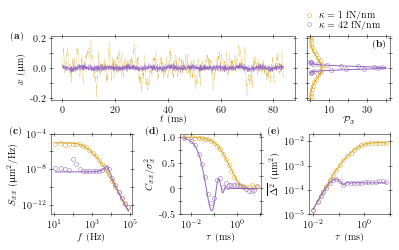

In [13]:
fig = plt.figure(figsize=(5.5, 3.3))
gs1 = fig.add_gridspec(1, 100, figure=fig, top=0.89, bottom=0.62, hspace=0.08, wspace=1, right=0.98)
gs2 = fig.add_gridspec(1, 3, figure=fig, bottom=0.14,  top=0.48, hspace=0.08, wspace=0.6, right=0.98)
tax1 = fig.add_subplot(gs1[0, :72])
probax1 = fig.add_subplot(gs1[0, 75:])
pax1 = fig.add_subplot(gs2[0, 0])
acfax1 = fig.add_subplot(gs2[0, 1])
msdax1 = fig.add_subplot(gs2[0, 2])
axs1 = [tax1, probax1, pax1, acfax1, msdax1]
axs1 = [tax1, probax1, pax1, acfax1, msdax1]



Npts = 8
acf_Npts = 9
ms = 4
mew=0.5
lw = 1
xpsdunit = (1e6)**2
msdunit = (1e6)**2
vpsdunit = (1e3)**2
vacfunit = (1e3)**2
xacfunit = (1e6)**2

colors = ["goldenrod", "C4"]
for Cx, Cv, color in zip(Cxs, Cvs, colors):
    k = Cx.k
    rho = Cx.rho
    T = Cx.T
    params = {"k":k, "rho":rho, "T":T, "R":R} 
    Cx.collection[0].plot(ax=axs1[0], unit="um", tunit="ms", tmax=taumax, lw=0.2, color=color)
    
    axs1[1].plot(gaussian_func(Cx.bins, var=kB*params["T"] / params["k"])/1e6, 1e6*Cx.bins, lw=lw, c=color, zorder=0)
    axs1[1].plot(Cx.hist/1e6, 1e6*Cx.bins, marker="o", ls="none", mec=color, mfc="none", ms=ms, mew=mew, 
                 label=r"$\kappa=%.0f~{\rm fN/nm}$"%(params["k"]*1e6)
                )
    
    xfreq_plot = logbin_func(Cx.freq, Npts=Npts)
    xpsd_plot = logbin_func(Cx.psd, Npts=Npts)
    axs1[2].loglog(xfreq_plot, xpsdunit*xpsd_plot, marker="o", ms=ms, mew=mew, mec=color, mfc="none", ls="none", label="x (sim)")
    axs1[2].loglog(np.geomspace(xfreq_plot[0], xfreq_plot[-1], 200), xpsdunit*psd_func(np.geomspace(xfreq_plot[0], xfreq_plot[-1], 200), **params), c=color, lw=lw, label="x (theory)")
   


    xmask = Cx.tacf < taumax*0.1
    xtacf_plot = logbin_func(Cx.tacf[xmask], Npts=acf_Npts)
    xacf_plot = logbin_func(Cx.acf[xmask], Npts=acf_Npts)
    axs1[3].semilogx(1e3*xtacf_plot, xacf_plot/np.mean([np.var(D.x) for D in Cx.collection]), marker="o", ms=ms, mew=mew, ls="none", mec=color, mfc="none", label="x (sim)")
    axs1[3].semilogx(1e3*np.geomspace(xtacf_plot[0], xtacf_plot[-1], 200), pac_func(np.geomspace(xtacf_plot[0], xtacf_plot[-1], 200), **params)/(kB*params["T"] / params["k"]), c=color, lw=lw, label="x (theory)")


    xmask = Cx.tmsd < taumax*0.1
    xtmsd_plot = logbin_func(Cx.tmsd[xmask], Npts=Npts)
    xmsd_plot = logbin_func(Cx.msd[xmask], Npts=Npts)
    axs1[4].loglog(1e3*xtmsd_plot, msdunit*xmsd_plot, marker="o", ms=ms, mew=mew, ls="none", mec=color, mfc="none", label="x (sim)")
    axs1[4].loglog(1e3*xtmsd_plot, msdunit*msd_func(xtmsd_plot, **params), c=color, lw=lw, label="x (theory)")
    


axs1[0].set_xlabel("$t$ (ms)", labelpad=-0.2)
axs1[0].set_ylabel(r"$x~{\rm (\upmu m)}$")
axs1[0].set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
axs1[0].set_yticklabels([-0.2, "", 0.0, "", 0.2])


axs1[1].set_xlabel(r"$\mathcal{P}_x$", labelpad=-0.2)
axs1[1].set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
axs1[1].set_yticklabels([])
axs1[1].set_yticklabels([])
axs1[1].set_xticks([0,10,20,30,40])
axs1[1].set_xticklabels(["", 10, "", 30, ""])
axs1[1].set_ylim(*axs1[0].get_ylim())


axs1[2].set_xlabel(r"$f$ (Hz)")
axs1[2].set_ylabel(r"$S_{xx}~{\rm (\upmu m^2 /Hz)}$")
psd_xticks = [1e1,1e2,1e3,1e4,1e5]
axs1[2].set_xticks(psd_xticks)
axs1[2].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(psd_xticks)])
xpsd_yticks = [1e-12, 1e-10, 1e-8, 1e-6, 1e-4]
axs1[2].set_yticks(xpsd_yticks)
axs1[2].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(xpsd_yticks)])



axs1[3].set_ylabel(r"$C_{xx}/\sigma^2_x$")
axs1[3].set_xlabel(r"$\tau$ (ms)")
sq_xticks = [1e-2,1e-1,1e0, 1e1]
axs1[3].set_xticks(sq_xticks)
axs1[3].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(sq_xticks)])
axs1[3].set_yticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
axs1[3].set_yticklabels([-0.5, "", 0, "", 0.5, "", 1.0])


axs1[4].set_xlabel(r"$\tau$ (ms)")
axs1[4].set_ylabel(r"$\overline{\Delta^2}~{\rm (\upmu m^2)}$")
axs1[4].set_xticks(sq_xticks)
axs1[4].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(sq_xticks)])
msd_yticks = [1e-5, 1e-4, 1e-3, 1e-2]
axs1[4].set_yticks(msd_yticks)
axs1[4].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if True else "" for di, d in enumerate(msd_yticks)])
axs1[4].set_ylim(top=2e-2)

lettering(axs1[0], -0.143, 1., 0)
lettering(axs1[1], 0.87, 0.87, 1)
lettering(axs1[2], -0.45, 1.03, 2)
lettering(axs1[3], -0.35, 1.03, 3)
lettering(axs1[4], -0.45, 1.03, 4)

axs1[1].legend(frameon=False, labelspacing=0, handletextpad=0, columnspacing=0.5, ncol=1,
               loc="lower left", bbox_to_anchor=(-0.2, 0.95))

plt.savefig("figures/dissertation/experiment_x-stats.pdf", dpi=600)

In [ ]:
for C in Cvs:
    C.average("PSD", taumax=taumax, window=window)
    C.average("ACF", taumax=taumax, n_jobs=1)
    C.average("MSD", taumax=taumax, n_jobs=1)
    C.average("HIST", Nbins=20)

In [ ]:
# K = [1e-6, 50e-6]

fig = plt.figure(figsize=(5.5, 3.5))
gs1 = fig.add_gridspec(1, 100, figure=fig, top=0.89, bottom=0.62, hspace=0.08, wspace=1, right=0.98)
gs2 = fig.add_gridspec(1, 4, figure=fig, bottom=0.12,  top=0.48, hspace=0.08, wspace=0.9, right=0.98)
tax1 = fig.add_subplot(gs1[0, :72])
probax1 = fig.add_subplot(gs1[0, 75:])
pax1 = fig.add_subplot(gs2[0, :2])
acfax1 = fig.add_subplot(gs2[0, 2:])

axs1 = [tax1, probax1, pax1, acfax1]
axs1 = [tax1, probax1, pax1, acfax1]


acf_Npts = 10
Npts = 7
ms = 4
mew=0.5
lw = 1
xpsdunit = (1e6)**2
msdunit = (1e6)**2
vpsdunit = (1e3)**2
vacfunit = (1e3)**2
xacfunit = (1e6)**2

colors = ["goldenrod", "C4"]
for Cx, Cv, color in zip(Cxs, Cvs, colors):
    k = Cv.k
    rho = Cv.rho
    T = Cv.T
    m = 4/3 *np.pi * rho * R**3
    params = {"k":k, "rho":rho, "T":T, "R":R} 
    print("k=", params["k"])
    
    Cv.collection[0].plot(ax=axs1[0], unit="mm_s", tunit="ms", tmax=taumax, lw=0.1, color=color)
    axs1[1].plot(gaussian_func(Cv.bins, var=kB*T / m)/1e3, 1e3*Cv.bins, lw=lw, c=color, zorder=0)
    axs1[1].plot(Cv.hist/1e3, 1e3*Cv.bins, marker="o", ls="none", mec=color, mfc="none", ms=ms, mew=mew, 
                 label=r"$\kappa=%.0f~{\rm fN/nm}$"%(params["k"]*1e6)
                )
    
    vfreq_plot = logbin_func(Cv.freq, Npts=Npts)
    vpsd_plot = logbin_func(Cv.psd, Npts=Npts)
    #vfreq_plot = np.array([Cv.freq[2**i] for i in range(int(np.log2(len(Cv.freq))))])
    #vpsd_plot = np.array([Cv.psd[2**i] for i in range(int(np.log2(len(Cv.psd))))])
    axs1[2].loglog(vfreq_plot[1:], vpsdunit*vpsd_plot[1:], marker="o", ms=ms, mew=mew, mec=color, mfc="none", ls="none", label="x (sim)")
    axs1[2].loglog(np.geomspace(vfreq_plot[0], vfreq_plot[-1], 200), (2*np.pi*np.geomspace(vfreq_plot[0], vfreq_plot[-1], 200))**2*vpsdunit*psd_func(np.geomspace(vfreq_plot[0], vfreq_plot[-1], 200), **params), c=color, lw=lw, label="x (theory)")
      
    vmask = Cv.tacf < taumax*0.1
    vtacf_plot = logbin_func(Cv.tacf[vmask], Npts=acf_Npts)
    vacf_plot = logbin_func(Cv.acf[vmask], Npts=acf_Npts)
    axs1[3].semilogx(1e3*vtacf_plot, vacfunit*vacf_plot, marker="o", ms=ms, mew=mew, ls="none", mec=color, mfc="none", label="x (sim)")
    axs1[3].semilogx(1e3*np.geomspace(vtacf_plot[0], vtacf_plot[-1], 200), vacfunit*vac_func(np.geomspace(vtacf_plot[0], vtacf_plot[-1], 200), **params), c=color, lw=lw, label="x (theory)")



axs1[0].set_xlabel("$t$ (ms)", labelpad=0.2)
axs1[0].set_ylabel(r"$v~{\rm (mm/s)}$")
axs1[0].set_yticks([-2, -1, 0.0, 1, 2])
axs1[0].set_yticklabels([-2, "", 0.0, "", 2])


axs1[1].set_xlabel(r"$\mathcal{P}_v$", labelpad=0.25)
axs1[1].set_yticks([-2, -1, 0.0, 1, 2])
axs1[1].set_yticklabels([])
axs1[1].set_xticks([0, 0.25, 0.5, 0.75, 1])
axs1[1].set_xticklabels([0.0, "", 0.5, "", 1.0])
axs1[1].set_ylim(*axs1[0].get_ylim())



axs1[2].set_xlabel(r"$f$ (Hz)")
axs1[2].set_ylabel(r"$S_{vv}~{\rm [(mm/s)^2/Hz]}$")
vpsd_yticks = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
axs1[2].set_yticks(vpsd_yticks)
axs1[2].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(vpsd_yticks)])

psd_xticks = [1e1,1e2,1e3,1e4,1e5]
axs1[2].set_xticks(psd_xticks)
axs1[2].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(psd_xticks)])

axs1[3].set_ylabel(r"$C_{vv}~{\rm [(mm/s)^2]}$")
axs1[3].set_yticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15])
axs1[3].set_yticklabels([-0.1, "", 0, "", 0.1, ""])
axs1[3].set_xlabel(r"$\tau$ (ms)")

sq_xticks = [1e-2,1e-1,1e0, 1e1]

axs1[3].set_xticks(sq_xticks)
axs1[3].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(sq_xticks)])


lettering(axs1[0], -0.113, 1., 0)
lettering(axs1[1], 0.87, 0.87, 1)
lettering(axs1[2], -0.1, 1.03, 2)
lettering(axs1[3], -0.1, 1.03, 3)

axs1[1].legend(frameon=False, labelspacing=0, handletextpad=0, columnspacing=0.5, ncol=1,
               loc="lower left", bbox_to_anchor=(-0.2, 0.95))

plt.savefig("figures/dissertation/experiment_v-stats.pdf", dpi=600)

In [ ]:
reload(brownian)
reload(time_series)

from time_series import CollectionWeighing
long_fnames = find_files(find_ders(run_ders[3])[0])



In [ ]:
Clong = CollectionWeighing(long_fnames)


In [ ]:
Clong.apply("AVAR", func=var_func, octave=True, Nmin=32, base=1.2);

In [ ]:
adev = np.mean(np.array([np.sqrt(D.avar) for D in Clong.collection]), axis=0)
dadev = np.std(np.array([np.sqrt(D.avar) for D in Clong.collection]), axis=0)
tadev = Clong.collection[0].tavar

In [ ]:
def powerlaw_fit(x, y):     
    m, b = np.polyfit(np.log10(x), np.log10(y), 1)      
    def func(x):         
        return 10**b * x**m     
    return func, m, b

In [ ]:
fig = plt.figure(figsize=(5.5, 3.5))
gs = fig.add_gridspec(2,2, figure=fig, top=0.98, bottom=0.13, hspace=0.5, wspace=0.15, right=0.98)

ax2 = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, :])

ii = 0
for Ci, C in enumerate(Cs):
    if Ci in idxs:
        color = colors[ii]
        ii += 1
        cal = C.cal * 1e9
        bins = C.Vbins * cal
        hist = C.Vhist / cal
        dhist = C.dVhist /cal
        var = C.Vvar * cal**2
        plot_bins = bins
        ax1.errorbar(bins[1:-1], hist[1:-1]/np.max(hist), yerr=dhist[1:-1]/np.max(hist), 
                     marker="o", ms=6, elinewidth=1,
                     mec=color, ecolor=color, capsize=2, mfc="none", mew=0.5, ls="none")
        ax1.plot(plot_bins, gaussian_func(plot_bins, var=var)/np.max(hist), color=color, lw=1)

ii = 0
for Ci, C in enumerate(Cs):
    if Ci in idxs:
        color = colors[ii]
        ii += 1
        cal = C.cal * 1e3
        k = C.popt_krhoA[0]
        bins = C.Vdotbins * cal
        hist = C.Vdothist / cal
        dhist = C.dVdothist / cal
        var = C.Vdotvar * cal**2
        plot_bins = bins
        ax2.errorbar(bins[1:-1], hist[1:-1]/np.max(hist), yerr=dhist[1:-1]/np.max(hist),  marker="o", ms=6, elinewidth=1,
                     mec=color, ecolor=color, capsize=2, mfc="none", mew=0.5, ls="none")
        ax2.plot(plot_bins, gaussian_func(plot_bins, var=var)/np.max(hist), color=color, lw=1,  
                 label=r"$\kappa=%.0f~{\rm fN/nm}$"%(k*1e6))

ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_ylabel("Prob. (arb. units)")
ax1.set_xlabel("$x$ (nm)")
ax2.set_xlabel("$v$ (mm/s)")
ax2.set_xticks([-2,-1,0,1,2])
ax1.set_xticks([-200,-100,0,100,200])
ax1.set_yticks([1, 1e-2, 1e-4])
ax2.set_yticks([1, 1e-2, 1e-4])
ax2.set_yticklabels([])
ax2.set_ylim(2e-5, 4)
ax1.set_ylim(2e-5, 4)
ax2.legend(frameon=False, handlelength=1)

norm = np.mean([np.var(D.x) for D in Clong.collection])

tmaskfit = np.logical_and(tadev>0, tadev<0.05)
ts_fit = np.geomspace(1e-3,30, 100)
func, m, b = powerlaw_fit(tadev[tmaskfit], 100*adev[tmaskfit]/norm)
ax3.loglog(ts_fit, func(ts_fit), lw=1, c="crimson")
print(m)

ax3.errorbar(tadev[:63], 100*adev[:63]/norm, yerr=100*dadev[:63]/norm, marker="o",
             ms=6, elinewidth=1,
            mec="k", ecolor="k", capsize=2, mfc="none", mew=0.5, ls="none"
            )
#plt.loglog(Clong.tnvar, nvar/norm)

#plt.loglog(Dold.txvaradev, 9*Dold.xvaradev)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylabel("Relative A. dev.\n"+ r"$\mathcal{A}_{V^2}/\sigma^2_{V}~(\%)$")
ax3.set_xlabel(r"Averaging time $\tau$ (s)")
ax3.set_xlim(right=500)
ax3.set_ylim(bottom=5e-1)
lettering(ax1, -0.08, 1, 0)
lettering(ax2, -0.08, 1, 1)
lettering(ax3, -0.08, 1, 2)
plt.savefig("figures/dissertation/variance_and_adev.pdf", dpi=600)

In [ ]:
    
markers = ["s", "d", "h"]     
colors = ["lightblue", "peru", "olivedrab"]   
fig, ax = plt.subplots(1,1, figsize=(5.5, 2))

  
m123s = []
dm123s = []
for idx in idxs_all:
    C = Cs[idx]
    m123 = get_m123(*C.popt_abc, R, C.Vvar, C.Vdotvar, C.T)
    jac_m123 = get_jac_m123(*C.popt_abc, R, C.Vvar, C.Vdotvar, C.T)
    cov_indeps = block_diag(C.pcov_abc, np.diag([C.dVdotvar, C.dVvar, dR, deta])**2)
    pcov_m123 = np.linalg.multi_dot([jac_m123, cov_indeps, jac_m123.T])
    dm123 = np.sqrt(np.diag(pcov_m123))
    m123s.append(m123)
    dm123s.append(dm123)
m123s = np.array(m123s)
dm123s = np.array(dm123s)
 
m123s = m123s * 1e3 * 1e12     
dm123s = dm123s * 1e3 * 1e12     
    
print("Mass measurements (pg)")    
print("======================")     

mman = 1e3*1e12*4*np.pi*2000*(R)**3/3    
dmman = np.sqrt((3*dR/R)**2 + 0.2**2)     
print("manufacturer:")     
print(f"    R=1.61, dR/R=0.03; rho=2.0. drho/rho=0.2")     
print(f"    m = {np.round(mman, 4)}; sys={np.round(dmman,4)}")     
for i, (marker, c) in enumerate(zip(markers, colors)):         
    m = m123s[:, i]         
    dm = dm123s[:, i]         
    x = Ps[idxs_all] + (i - 1) * 0  # horizontal offset         
    print(f"m{i+1}:")        
    print(f"    average value: {np.round(np.mean(m), 3)}")         
    print(f"    sys: {np.round(np.mean(dm) / np.mean(m), 4)}; stat: {np.round(np.std(m) / np.mean(m), 4)}")
    ax.errorbar(             
        x,            
        m,
        yerr=dm,            
        ls="none",            
        marker=marker,            
        ms=6,            
        mec="k",
        mew=0.5,
        elinewidth=1,
        capsize=2,
        ecolor=c,            
        c=c,            
        label=r"$m_{%s}$" % (i + 1),         )   
    #ax.axhline(mman, c="k")     
    #ax.axhspan(mman*(1+dmman), mman*(1-dmman), color="k", alpha=0.2)     
    ax.set_xlabel(r"$\mathrm{Total~Power}~P$ (mW)")     
    ax.set_ylabel(r"$\mathrm{Mass}~m$ (pg)")     
    #_to_anchor=(0.5, 
    #ax.legend(     #    loc="lower center",     #    bbox0.95),     #    ncol=3,     #    handlelength=0.4,     #    handletextpad=0.3,     #    columnspacing=2,     #    frameon=False,     #)     
    ax.legend(loc="upper left", bbox_to_anchor=(0.05,0.98), ncol=3, handlelength=0.4, handletextpad=0.3, columnspacing=2)     
    ax.set_yticks([22, 23.5, 25, 26.5, 28, 29.5, 31, 32.5])     
    ax.set_yticklabels([22, "", 25, "", 28, "", 31, ""])     
    ax.set_xticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275])     
    ax.set_xticklabels([0, "", 50, "", 100, "", 150, "", 200, "", 250, ""])
plt.tight_layout(pad=0.1)
plt.savefig("figures/dissertation/mass_results.pdf", dpi=600)

In [ ]:
from brownian import get_viscosity

In [ ]:
print(R)
print(dR/R)

In [ ]:
print(np.mean([get_viscosity(Cs[idx].T, RH=50) for idx in idxs_all]))
print(deta/np.mean([get_viscosity(Cs[idx].T, RH=50) for idx in idxs_all]))
print(np.std([get_viscosity(Cs[idx].T, RH=50) for idx in idxs_all])/np.mean([get_viscosity(Cs[idx].T, RH=50) for idx in idxs_all]))

In [ ]:
Ts = np.mean([Cs[idx].T for idx in idxs_all])
print(Ts)
print(dT / np.mean([Cs[idx].T for idx in idxs_all]))
print(np.std([Cs[idx].T for idx in idxs_all]) / np.mean([Cs[idx].T for idx in idxs_all]))

In [ ]:
Vdotvars =  np.array([Cs[idx].Vdotvar for idx in idxs_all])
dVdotvars = np.array([Cs[idx].dVdotvar for idx in idxs_all])
Vvars =  np.array([Cs[idx].Vvar for idx in idxs_all])
dVvars = np.array([Cs[idx].dVvar for idx in idxs_all])               

In [ ]:
plt.errorbar(Ps[idxs_all], Vdotvars, yerr=dVdotvars)
print(np.mean(Vdotvars)*(1e3/1e6)**2)
print(np.mean(dVdotvars/Vdotvars))
print(np.std(Vdotvars)/np.mean(Vdotvars))

In [ ]:
plt.errorbar(Ps[idxs_all], Vvars, yerr=dVvars)
print(np.min(Vvars)*1e4, np.max(Vvars))
print(np.mean(dVvars/Vvars))

In [ ]:
ks, rhos, As = krhoAs
dks, drhos, dAs = dkrhoAs
m, b = np.polyfit(Ps[idxs_all], ks, deg=1)
print(np.min(ks*1e6), np.max(ks*1e6))
print(np.mean(dks/ks))
print(np.mean((ks - (m*Ps[idxs_all] + b))/ks))

In [ ]:
print(np.mean(rhos)*1e-3)
print(np.mean(drhos/rhos))
print(np.std(rhos)/np.mean(rhos))

In [ ]:
print(np.mean(As)*1e-6)
print(np.mean(dAs/As))
print(np.std(As)/np.mean(As))

In [ ]:
get_params()

In [ ]:
np.mean([Cs[idx].params["PDF-mW"]/Cs[idx].params["PDB-mW"] for idx in idxs_all])
np.max([Cs[idx].params["PDF-mW"]/Cs[idx].params["PDB-mW"] for idx in idxs_all]),np.min([Cs[idx].params["PDF-mW"]/Cs[idx].params["PDB-mW"] for idx in idxs_all])

In [ ]:
Ps[idxs_all]